# Vehicle Detection
In this Jupyter Notebook, we will try to detect vehicles from images and videos feeds using computer vision and machine learning tecniques.

The main objectivs of this project will be as follows:
* Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier
* Optionally, you can also apply a color transform and append binned color features, as well as histograms of color, to your HOG feature vector.
* Note: for those first two steps don't forget to normalize your features and randomize a selection for training and testing.
* Implement a sliding-window technique and use your trained classifier to search for vehicles in images.
* Run your pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
* Estimate a bounding box for vehicles detected.

## Getting Started
There are many features that we can consider extracting from an image or a video frame. We can first take a look at the images that we have in the training set.

In [193]:
## import needed packages
from scipy.ndimage.measurements import label
from skimage.feature import hog
from sklearn.svm import LinearSVC, SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, RobustScaler
from skimage.feature import hog

import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pickle
import cv2
import glob
import time

%matplotlib inline

In [2]:
## import training images
veh_images = glob.glob('./training_images/vehicles/**/*.png')
nonveh_images = glob.glob('./training_images/non-vehicles/**/*.png')

print("Vehicle Images: "+str(len(veh_images)))
print("Non-vehicle Images: "+str(len(nonveh_images)))

Vehicle Images: 8792
Non-vehicle Images: 8968


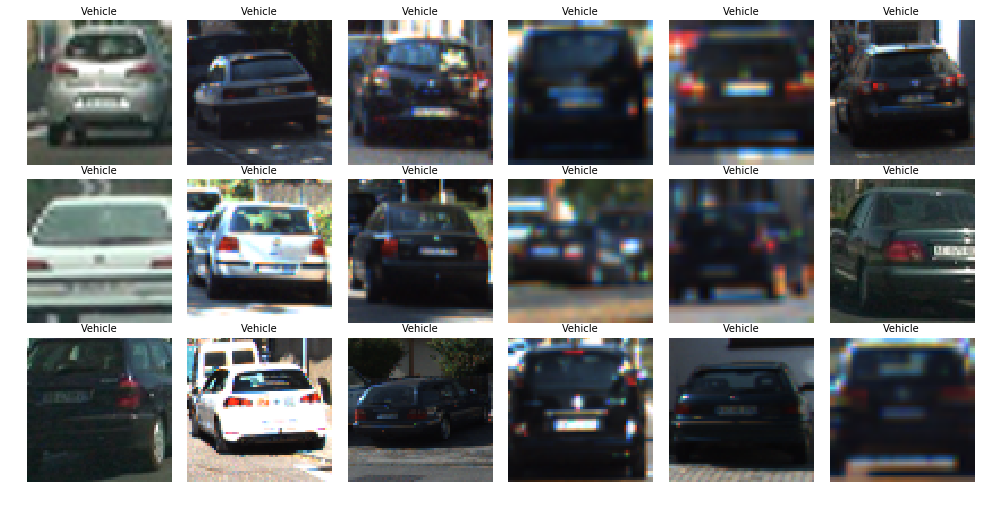

In [3]:
## plot vehicles
f, ax = plt.subplots(3,6, figsize=(14, 7))
f.tight_layout()
f.subplots_adjust(hspace = .1, wspace=.05)
ax = ax.ravel()

# Step through the list and search for chessboard corners
for i in range(18):
    img1 = cv2.imread(veh_images[np.random.randint(0,len(veh_images))])
    img1 = cv2.cvtColor(img1,cv2.COLOR_BGR2RGB)
    ax[i].axis('off')
    ax[i].set_title('Vehicle', fontsize=10)
    ax[i].imshow(img1)
    
## save image for write up
# f.savefig("/Users/jwen/Python/Projects/sdcnd_vehicle_detection/output_images/vehicles.png")

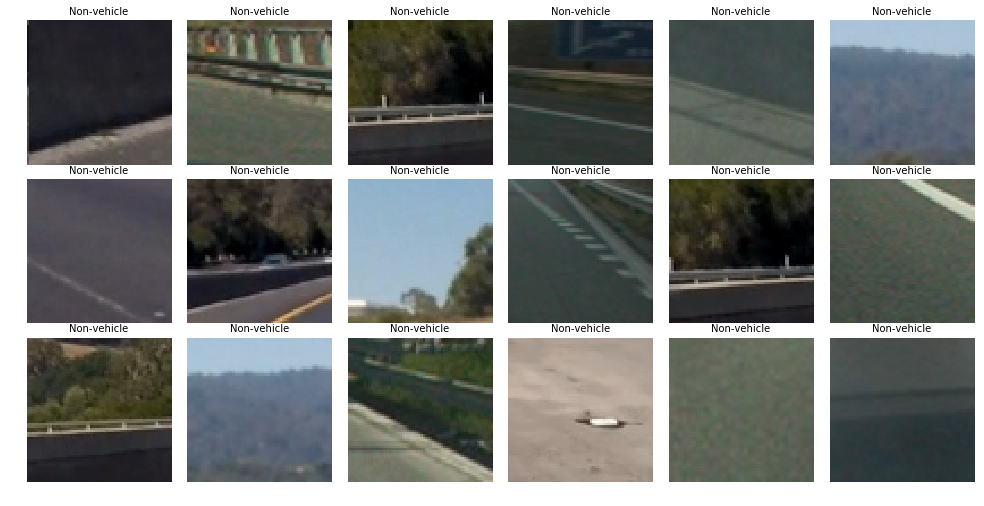

In [4]:
## plot non-vehicles
f, ax = plt.subplots(3,6, figsize=(14, 7))
f.tight_layout()
f.subplots_adjust(hspace = .1, wspace=.05)
ax = ax.ravel()

# Step through the list and search for chessboard corners
for i in range(18):
    img1 = cv2.imread(nonveh_images[np.random.randint(0,len(nonveh_images))])
    img1 = cv2.cvtColor(img1,cv2.COLOR_BGR2RGB)
    ax[i].axis('off')
    ax[i].set_title('Non-vehicle', fontsize=10)
    ax[i].imshow(img1)
    
## save image for write up
# f.savefig("/Users/jwen/Python/Projects/sdcnd_vehicle_detection/output_images/non_vehicles.png")

As expected, the images above show cars are various zooms, crops, and angles while the non-vehicle images show scenes do not contain any cars. We can use these images to extract relevant features, which will ultimately be used to train our classifier. 

[(754, 506), (574, 680)]


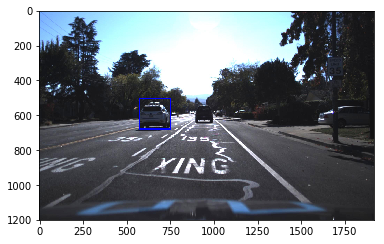

In [254]:
## using additional images from https://github.com/udacity/self-driving-car/tree/master/annotations
labels_df = pd.read_csv("/Users/jwen/Python/Projects/sdcnd_vehicle_detection/training_images/crowdai_labels.csv")
car_labels = labels_df[labels_df['Label']=='Car'].reset_index()

car_labels['window'] = car_labels.apply(lambda x: [(x['ymin'],x['xmax']),(x['xmin'], x['ymax'])], axis=1)
car_labels

## read in image
crowdai_path = "/Users/jwen/Python/Projects/sdcnd_vehicle_detection/training_images/object-detection-crowdai/"
image = cv2.imread(crowdai_path+car_labels.ix[4152,'Frame'])
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

blah_image = draw_boxes(image, [car_labels.ix[4152,'window']])
print(car_labels.ix[4152,'window'])

plt.imshow(blah_image)
# blah = cv2.resize(image[windows[2107][0][1]:windows[2107][1][1], windows[2107][0][0]:windows[2107][1][0]], (64, 64))


In [225]:
car_labels.ix[25,'Frame']

'1479498373962951201.jpg'

In [194]:
!pwd

/Users/jwen/Python/Projects/sdcnd_vehicle_detection


## Extracting Features
### Histogram of Gradients
First, we can try to extract the histogram of gradients. The gradients of an image will help to identify the structures within the image. On the otherhand, if we use color, it might be difficult to extract the relavant features because the same model car can be different colors. The gradient is able to capture the edges of the shape of the car. We use a modified version that averages the gradients across multiple cells to account for some possible noise in the image.

In [5]:
## hog extractor function (from exercise) to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True):
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell), cells_per_block=(cell_per_block, cell_per_block), visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell), cells_per_block=(cell_per_block, cell_per_block), visualise=vis, feature_vector=feature_vec)
        return features

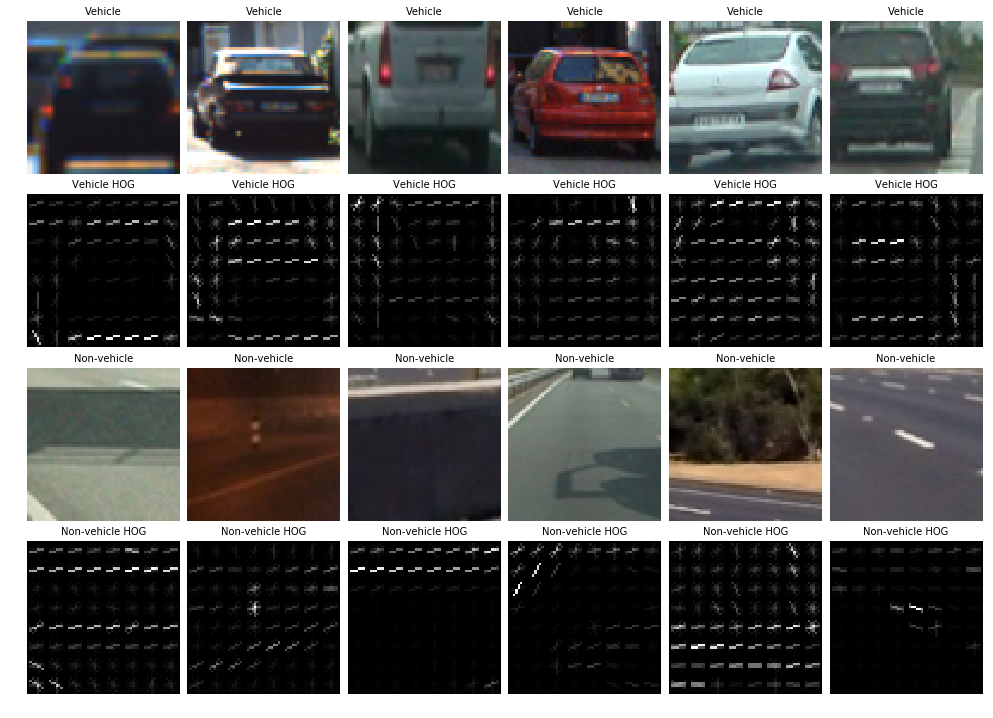

In [11]:
## plot images
f, ax = plt.subplots(4,6, figsize=(14, 10))
f.tight_layout()
f.subplots_adjust(hspace = .1, wspace=.05)
ax = ax.ravel()
    
# Define HOG parameters
orient = 9
pix_per_cell = 8
cell_per_block = 2

# Step through the list and search for chessboard corners
for i in range(6):
    ## plot img
    img1 = cv2.imread(veh_images[np.random.randint(0,len(veh_images))])
    img1 = cv2.cvtColor(img1,cv2.COLOR_BGR2RGB)
    ax[i].axis('off')
    ax[i].set_title('Vehicle', fontsize=10)
    ax[i].imshow(img1)
    
    ## plot hog
    gray = cv2.cvtColor(img1, cv2.COLOR_RGB2GRAY)
    _, hog_img = get_hog_features(gray, orient, pix_per_cell, cell_per_block, vis=True, feature_vec=False)
    ax[i+6].axis('off')
    ax[i+6].set_title('Vehicle HOG', fontsize=10)
    ax[i+6].imshow(hog_img, cmap='gray')

# Step through the list and search for chessboard corners
for i in range(12,18):
    ## plot img
    img1 = cv2.imread(nonveh_images[np.random.randint(0,len(nonveh_images))])
    img1 = cv2.cvtColor(img1,cv2.COLOR_BGR2RGB)
    ax[i].axis('off')
    ax[i].set_title('Non-vehicle', fontsize=10)
    ax[i].imshow(img1)
    
    ## plot hog
    gray = cv2.cvtColor(img1, cv2.COLOR_RGB2GRAY)
    _, hog_img = get_hog_features(gray, orient, pix_per_cell, cell_per_block, vis=True, feature_vec=False)
    ax[i+6].axis('off')
    ax[i+6].set_title('Non-vehicle HOG', fontsize=10)
    ax[i+6].imshow(hog_img, cmap='gray')
    
## save image for write up
# f.savefig("/Users/jwen/Python/Projects/sdcnd_vehicle_detection/output_images/hog_examples.png")

Awesome, we can look closely at the HOG visualizations and see that the gradients seem to capture the shape of the vehicles quite well. If we compare the HOG visualizations of the vehicles vs. the non-vehicles, we can see that there is a difference between the different types of images.

Next, we can explore another set of features: color.

### Color Related Features
We can imagine that the color of vehicles will be slightly different when compared to the non-vehicle images. Specifically, in some cases the vehicles are usually more saturated when compared to a pale background. Let's take a closer look and use a function to extract the color histogram of the image.

In [12]:
## function to compute color histogram features  
def color_hist(img, nbins=32, bins_range=(0, 256)):
    
    ## compute the histogram of the RGB channels separately
    rhist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    ghist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    bhist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    
    ## generating bin centers
    bin_edges = rhist[1]
    bin_centers = (bin_edges[1:]  + bin_edges[0:len(bin_edges)-1])/2
    
    ## concatenate the histograms into a single feature vector
    hist_features = np.concatenate((rhist[0], ghist[0], bhist[0]))
    
    # return the individual histograms, bin_centers, and feature vector
    return rhist, ghist, bhist, bin_centers, hist_features

<Container object of 32 artists>

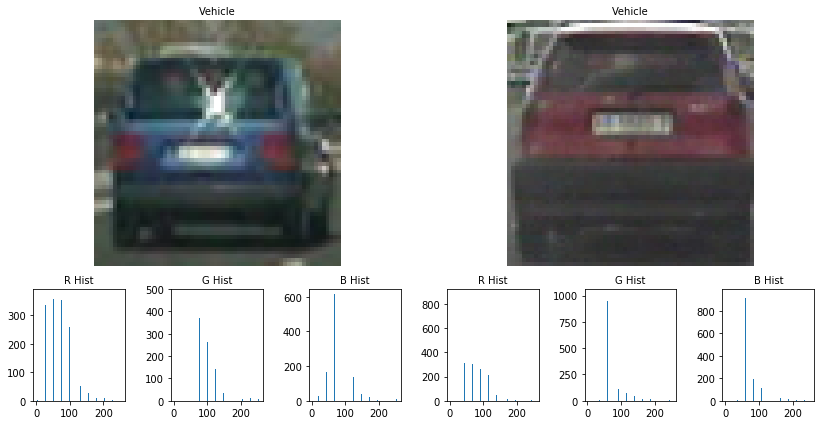

In [13]:
## setup figure
f = plt.figure(figsize=(14, 7))
f.subplots_adjust(hspace = .2, wspace=.5)

## read image 1
img1 = cv2.imread(veh_images[200])
img1 = cv2.cvtColor(img1,cv2.COLOR_BGR2RGB)
rh, gh, bh, bincen, feature_vec = color_hist(img1, nbins=32, bins_range=(0, 256))

## plot image
ax1 = plt.subplot2grid((3,6), (0,0), rowspan=2, colspan=3)
ax1.axis('off')
ax1.set_title('Vehicle', fontsize=10)
ax1.imshow(img1)

## R Hist
ax3 = plt.subplot2grid((3,6), (2,0))
ax3.set_title('R Hist', fontsize=10)
ax3.bar(bincen, rh[0])

## G hist
ax4 = plt.subplot2grid((3,6), (2,1))
ax4.set_title('G Hist', fontsize=10)
ax4.bar(bincen, gh[0])

## b hist
ax5 = plt.subplot2grid((3,6), (2,2))
ax5.set_title('B Hist', fontsize=10)
ax5.bar(bincen, bh[0])


## read image 2
img1 = cv2.imread(veh_images[2130])
img1 = cv2.cvtColor(img1,cv2.COLOR_BGR2RGB)
rh, gh, bh, bincen, feature_vec = color_hist(img1, nbins=32, bins_range=(0, 256))

## plot image
ax2 = plt.subplot2grid((3,6), (0,3), rowspan=2, colspan=3)
ax2.axis('off')
ax2.set_title('Vehicle', fontsize=10)
ax2.imshow(img1)

## R Hist
ax6 = plt.subplot2grid((3,6), (2,3))
ax6.set_title('R Hist', fontsize=10)
ax6.bar(bincen, rh[0])

## G hist
ax7 = plt.subplot2grid((3,6), (2,4))
ax7.set_title('G Hist', fontsize=10)
ax7.bar(bincen, gh[0])

## b hist
ax8 = plt.subplot2grid((3,6), (2,5))
ax8.set_title('B Hist', fontsize=10)
ax8.bar(bincen, bh[0])

## save image for write up
# f.savefig("/Users/jwen/Python/Projects/sdcnd_vehicle_detection/output_images/color_hist.png")

We can also take into account the raw pixel values. However, there might be too many features if we do that so we can reduce the size of the image to return a slightly lower resolution image with the same features.

In [14]:
# function to compute binned color features  
def bin_spatial(img, color_space='RGB', size=(32, 32)):
    
    ## convert image to new color space (if specified)
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: 
        feature_image = np.copy(img)             
    
    ## use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(feature_image, size).ravel() 
    
    return features

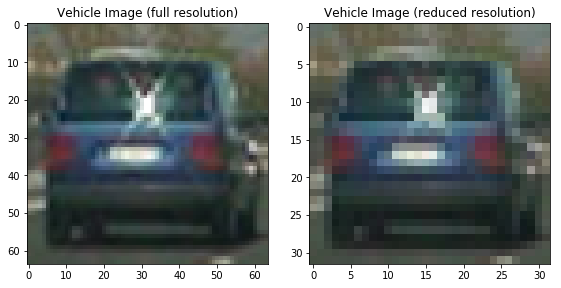

In [15]:
## read image 1
img1 = cv2.imread(veh_images[200])
img1 = cv2.cvtColor(img1,cv2.COLOR_BGR2RGB)

## take a look at the reduced resolution image
feature_vec = bin_spatial(img1, color_space='RGB', size=(32, 32))

## plot the images
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 6))
f.tight_layout()

ax1.imshow(img1)
ax1.set_title('Vehicle Image (full resolution)', fontsize=12)

ax2.imshow(feature_vec.reshape((32,32,3)))
ax2.set_title('Vehicle Image (reduced resolution)', fontsize=12)

## save image for write up
# f.savefig("/Users/jwen/Python/Projects/sdcnd_vehicle_detection/output_images/spatial_bin.png")

We can see that in the above image the vehicle image on the right has a lower resolution but still captures most of the color information that we see in the original image.

At this point we have quite a few techniques to extract both color and gradient information from the images. We can define a pipeline to extract these features. Note that if and when we combine the color and gradient features we need to normalize and scale the features so that the different scales of the features do not adversely affect the classifier that we will build.

In [57]:
## function to extract features
def extract_features(imgs, cspace='RGB', spatial_size=(32, 32), hist_bins=32, hist_range=(0, 256),
                     orient=9, pix_per_cell=8, cell_per_block=2, hog_channel=0, 
                     spatial_feat=False, color_feat=False, hog_feat=True):
    ## create a list to append feature vectors to
    features = []
    
    ## iterate through the list of images
    for file in imgs:
        ## image features
        img_features = []
        
        ## read in each one by one
        img = mpimg.imread(file)
        
        ## apply color conversion if other than 'RGB'
        if cspace != 'RGB':
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
            elif cspace == 'YCrCb':
                feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
        else: 
            feature_image = np.copy(img)      
        
        ## get spatial binning features
        if spatial_feat:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            img_features.append(spatial_features)
        
        ## get color features
        if color_feat:
            rh, gh, bh, bincen, hist_features = color_hist(feature_image, nbins=hist_bins, bins_range=hist_range)
            img_features.append(hist_features)
        
        if hog_feat:
            ## get hog features
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            img_features.append(hog_features)
            
        ## append features to overall feature set
        features.append(np.concatenate(img_features))
        
    # Return list of feature vectors
    return features


## function to extract features from a single image
def single_img_features(img, cspace='RGB', spatial_size=(32, 32), hist_bins=32, hist_range=(0, 256), 
                        orient=9, pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):    
    
    ## define an empty list to receive features
    img_features = []
    
    ## apply color conversion if other than 'RGB'
    if cspace != 'RGB':
        if cspace == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif cspace == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif cspace == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif cspace == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif cspace == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: 
        feature_image = np.copy(img)      
        
    ## spatial features
    if spatial_feat:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        img_features.append(spatial_features)
        
    ## color features
    if hist_feat:
        rh, gh, bh, bincen, hist_features = color_hist(feature_image, nbins=hist_bins, bins_range=hist_range)
        img_features.append(hist_features)
        
    ## HOG features
    if hog_feat:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        
        ## append features to list
        img_features.append(hog_features)

    ## return concatenated array of features
    return np.concatenate(img_features)

## Classifying Images
With the pipeline for feature extraction built, we can build a classifier to see how the feature extraction and model performs. We will have to play with the different parameters to be able to identify the best set of parameters.

In [137]:
## define parameters for feature extraction
color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 32
pix_per_cell = 16
cell_per_block = 2
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
spatial_size = (16, 16)
hist_bins = 16
hist_range=(0,256)
spatial_feat = False
color_feat = False
hog_feat = True

t=time.time()
## extract vehicle image features
car_features = extract_features(veh_images, cspace=color_space, spatial_size=spatial_size, hist_bins=hist_bins, 
                                hist_range=hist_range, orient=orient, pix_per_cell=pix_per_cell, 
                                cell_per_block=cell_per_block, hog_channel=hog_channel, spatial_feat=spatial_feat, 
                                color_feat=color_feat, hog_feat=hog_feat)

print('Total vehicle images: ', len(car_features))

## extract non vehicle image features
notcar_features = extract_features(nonveh_images, cspace=color_space, spatial_size=spatial_size, hist_bins=hist_bins, 
                                   hist_range=hist_range, orient=orient, pix_per_cell=pix_per_cell, 
                                   cell_per_block=cell_per_block, hog_channel=hog_channel, spatial_feat=spatial_feat, 
                                   color_feat=color_feat, hog_feat=hog_feat)

print('Total non-vehicle images: ', len(notcar_features)) 
t2 = time.time()

print(round(t2-t, 2), 'seconds to extract features')

Total vehicle images:  8792
Total non-vehicle images:  8968
65.12 seconds to extract features


In [138]:
## combine observations
X = np.vstack((car_features, notcar_features)).astype(np.float64)

## fit a per-column scaler
# X_scaler = StandardScaler().fit(X)
X_scaler = RobustScaler().fit(X)

## apply the scaler to X
scaled_X = X_scaler.transform(X)

## define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

## split up data into randomized training and test sets
rand_state = 999
X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.2, random_state=rand_state)

In [139]:
## print result of the model
print('Using:',orient,'orientations',pix_per_cell,'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))

## use random forest
rf = RandomForestClassifier()

## check the training time for the RF
t=time.time()
rf.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'seconds to train RF')

## check the score of the RF
print('Test Accuracy of RF = ', round(rf.score(X_test, y_test), 4))

## check the prediction time for a single sample
t=time.time()
n_predict = 10
print('Model predicts: ', rf.predict(X_test[0:n_predict]))
print('Actual labels:  ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with RF')

Using: 32 orientations 16 pixels per cell and 2 cells per block
Feature vector length: 3456
10.14 seconds to train RF
Test Accuracy of RF =  0.9614
Model predicts:  [ 0.  1.  0.  0.  0.  0.  1.  1.  0.  1.]
Actual labels:   [ 0.  1.  0.  0.  0.  0.  1.  1.  0.  1.]
0.00261 Seconds to predict 10 labels with RF


We can use grid search to find the best parameters for our random forest model.

In [20]:
## random forest with grid search
## set of parameters to try in grid search for random forest
# param_grid = {"n_estimators":[15,50,100],
#               "min_samples_split": [5,7,9],
#               "min_samples_leaf": [1,3,5],
#               "max_leaf_nodes": [None,3,5],
#               }

# rf = RandomForestClassifier(n_jobs=3)

# ## timer for grid searching
# t = time.time()
# rf = GridSearchCV(rf, param_grid, cv=3)
# rf.fit(X_train, y_train)
# t2 = time.time()
# print("Elapsed time for grid search cv: {}".format(t2-t))

# ## used with grid search
# print(rf.best_score_)
# print(rf.best_params_)

## best params: {'n_estimators': 50, 'max_leaf_nodes': None, 'min_samples_split': 7, 'min_samples_leaf': 1}
## best score: 0.992117117117

In [140]:
## print result of the model
print('Using:',orient,'orientations',pix_per_cell,'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))

## use random forest
rf_1 = RandomForestClassifier(n_estimators=50, min_samples_split=7, min_samples_leaf=1)

## check the training time for the RF
t=time.time()
rf_1.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'seconds to train RF')

## check the score of the RF
print('Test Accuracy of RF = ', round(rf_1.score(X_test, y_test), 4))

## check the prediction time for a single sample
t=time.time()
n_predict = 10
print('Model predicts: ', rf_1.predict(X_test[0:n_predict]))
print('Actual labels:  ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with RF')

Using: 32 orientations 16 pixels per cell and 2 cells per block
Feature vector length: 3456
44.92 seconds to train RF
Test Accuracy of RF =  0.9766
Model predicts:  [ 0.  1.  0.  0.  0.  0.  1.  1.  0.  1.]
Actual labels:   [ 0.  1.  0.  0.  0.  0.  1.  1.  0.  1.]
0.00629 Seconds to predict 10 labels with RF


In [ ]:
## train the model on all of the data
rf_final = RandomForestClassifier(n_estimators=50, min_samples_split=7, min_samples_leaf=1)
rf_final.fit(scaled_X, y)

The grid search returned parameters that performed better than the standard model! We can also try to use gradient boosted trees, which are more robust.

In [ ]:
## print result of the model
print('Using:',orient,'orientations',pix_per_cell,'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))

## use random forest
gbc = GradientBoostingClassifier()

## check the training time for the GBC
t=time.time()
gbc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'seconds to train GBC')

## check the score of the GBC
print('Test Accuracy of GBC = ', round(gbc.score(X_test, y_test), 4))

## check the prediction time for a single sample
t=time.time()
n_predict = 10
print('Model predicts: ', gbc.predict(X_test[0:n_predict]))
print('Actual labels:  ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with GBC')

It seems like the base version of the classifier without any parameter tuning performs better than the random forest; however, because it takes so long to train, it might be better to use the parameter turned random forest or the gradient boosted classifier without parameter tuning.

In [147]:
## print result of the model
print('Using:',orient,'orientations',pix_per_cell,'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))

## use SVC
svc = linearSVC()

## check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'seconds to train SVC')

## check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))

## check the prediction time for a single sample
t=time.time()
n_predict = 10
print('Model predicts: ', svc.predict(X_test[0:n_predict]))
print('Actual labels:  ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

Using: 32 orientations 16 pixels per cell and 2 cells per block
Feature vector length: 3456
131.53 seconds to train SVC
Test Accuracy of SVC =  0.9921
Model predicts:  [ 0.  1.  0.  0.  0.  0.  1.  1.  0.  1.]
Actual labels:   [ 0.  1.  0.  0.  0.  0.  1.  1.  0.  1.]
0.09297 Seconds to predict 10 labels with SVC


## Sliding Window
Now that our classifier can identify if an image or a frame of a video contains a car, we need to find a way to look through the image to search for potential car matches so that we can run it against our classfier. One idea is to use a sliding window approach to scan through the image to identify possible car-like objects, then pass it to our classifier.

In [22]:
## function that creates sliding windows (from lesson)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                 xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    
    ## if x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
        
    ## compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    
    ## compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    
    ## compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    
    ## initialize a list to append window positions to
    window_list = []
    
    ## loop through finding x and y window positions
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            
            ## calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            
            ## append window position to list
            window_list.append(((startx, starty), (endx, endy)))
            
    return window_list

## function so search through an image
def search_windows(img, windows, clf, scaler, cspace='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    ## create an empty list to receive positive detection windows
    on_windows = []
    
    ## iterate over all windows in the list
    for window in windows:
        
        ## extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        
        ## extract features for that window using single_img_features()
        features = single_img_features(test_img, cspace=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=color_feat, hog_feat=hog_feat)
        
        ## scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        
        ## predict using your classifier
        prediction = clf.predict(test_features)
        ## if positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
            
    ## return windows for positive detections
    return on_windows

## function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    
    ## make a copy of the image
    imcopy = np.copy(img)
    
    ## iterate through the bounding boxes
    for bbox in bboxes:
        
        ## draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)

    return imcopy

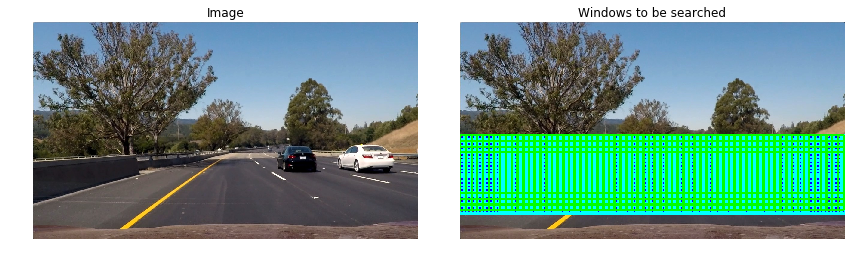

In [223]:
## read in the file paths to the test images
test_imgs = glob.glob('./test_images/*.jpg')

## read in image
image = cv2.imread(test_imgs[5])
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
# image = image.astype(np.float32)/255

## create boundary for search
y_start_stop = [375, 640]

## create windows to be searched
window_sizes = [96, 128, 192]
colors = [(0,0,255),(0,255,255),(0,255,0)]
windows_img = np.copy(image)
windows = []

for idx, window_size in enumerate(window_sizes):
    ## find windows at different scales
    temp_windows = slide_window(image, x_start_stop=[None, None], y_start_stop=y_start_stop, 
                           xy_window=(window_size, window_size), xy_overlap=(0.9, 0.9))
    
    ## adding the new windows
    windows += temp_windows

    ## draw windows on the original image
    windows_img = draw_boxes(windows_img, temp_windows, color=colors[idx])

## plot the images
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 10))
f.tight_layout()

ax1.imshow(image)
ax1.axis('off')
ax1.set_title('Image', fontsize=12)

ax2.imshow(windows_img)
ax2.axis('off')
ax2.set_title('Windows to be searched', fontsize=12)

## save image for write up
# f.savefig("/Users/jwen/Python/Projects/sdcnd_vehicle_detection/output_images/search_windows.png")

Next we can search the windows specified above for presence of vehicles.

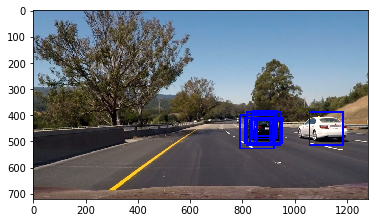

In [224]:
## search windows and classify cars
hot_windows = search_windows(image, windows, rf, X_scaler, cspace=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=color_feat, hog_feat=hog_feat)                       

## draw boxes around possible cars
window_img = draw_boxes(image, hot_windows)                    

plt.imshow(window_img)

[ 0.]


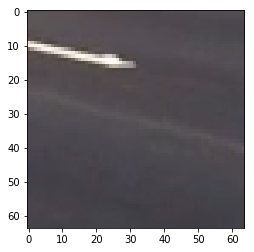

In [192]:
blah = cv2.resize(image[windows[2107][0][1]:windows[2107][1][1], windows[2107][0][0]:windows[2107][1][0]], (64, 64))


blah_feat = single_img_features(blah, cspace=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=color_feat, hog_feat=hog_feat)

blah_feat_scaled = X_scaler.transform(np.array(blah_feat).reshape(1, -1))
        
## predict using your classifier
blah_prediction = rf.predict(blah_feat_scaled)


print(blah_prediction)

# plt.imshow(draw_boxes(image,[windows[2107]]))
plt.imshow(blah)



In [211]:
windows[2107]

((1143, 510), (1239, 606))

In [ ]:
# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins):
    
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            rh, gh, bh, bincen, hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            test_prediction = clf.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
                
    return draw_img

## function to convert image color
def convert_color(img, conv='RGB2YCrCb'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)

In [ ]:
ystart = 400
ystop = 656
scale = 2
    
out_img = find_cars(image, ystart, ystop, scale, rf_final, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)

plt.imshow(out_img)

In [ ]:
img